In [105]:
# required packages
import os
import csv
from shapely.geometry import Point, LineString, Polygon, MultiPoint, mapping,shape
from fiona import collection
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from bokeh.plotting import figure, save
import pysal


# SHAPELY + FIONA = GIS ftw!

### What is Shapely?
> Shapely is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries.  

### Why should I use it? 


> - The first premise of Shapely is that Python programmers should be able to **perform PostGIS type geometry operations outside of an RDBMS**... if there’s no mandate to manage (the “M” in “RDBMS”) the data over time in the database we’re using the wrong tool for the job

> - The second premise is that the **persistence, serialization, and map projection** of features are significant, but *orthogonal problems*.

> - The third premise is that **Python idioms trump GIS** (or Java, in this case, since the GEOS library is derived from JTS, a Java project) idioms.

(source: [Shapely Docs](http://toblerity.org/shapely/manual.html))


...which means that you should/could use Shapely whenever you need to build or perform fast, off-the-shelf, customisable operations on geographic features that adhere to the [open geospatial community standards](http://www.opengeospatial.org/). 

Always be mindful though that, while Shapely is great for working on your spatial data geometries, it **does NOT** take care of their geographic dimension, i.e. it treats data as entities on a flat Euclidean plane, it does not consider any geographic projection (but there's [Fiona](https://github.com/Toblerity/Fiona) for that!).

### How does it work?

![](../imgs/640px-Venn_A_intersect_B.svg.png)
(photograph by [Cepheus](https://commons.wikimedia.org/wiki/File:Venn_A_intersect_B.svg), distributed under a CC-BY 2.0 license).
 
 
Shapely's conceptualisation of geographic features is built on predicates borrowed from [Set Theory](https://en.wikipedia.org/wiki/Set_theory)  a branch of mathematics that studies **sets**, or informal collections of objects.


### Spatial Data Model 

Shapely's **Spatial Data Model** is composed by three geometrical primitives (*Points, Curves* and *Surfaces*) represented by  three collection, or sets, of points in the plane. These are the *interior*, *boundary* and *exterior* sets; each mutually exclusive to the others.

Thus, to represent a **Point** Shapely uses
>...an interior set of exactly one point, a boundary set of exactly no points, and an exterior set of all other points.

a **Curve** is associated with 
> ...an interior set consisting of the infinitely many points along its length (imagine a Point dragged in space), a boundary set consisting of its two end points, and an exterior set of all other points

while a **Surface** has
> an interior set consisting of the infinitely many points within (imagine a Curve dragged in space to cover an area), a boundary set consisting of one or more Curves, and an exterior set of all other points including those within holes that might exist in the surface
(source: [Shapely Docs](http://toblerity.org/shapely/manual.html))

This (really brief) theory dive is fundamental to understand the Shapely's way of "seeing" data, and allows a more proficient use of its API.

Dimensionally Extended Nine-Intersection Model (DE-9IM)
http://giswiki.hsr.ch/images/3/3d/9dem_springer.pdf


## Let's build something from scratch with Shapely

Starting with simple points!

In [27]:
# let's create some points
# FIRST LONG THEN LAT!!!
domm = Point(9.191068,45.464041)
opendot = Point(9.221946, 45.447798)

# check everything went fine
print "opendot is a {} and this is its type: {}".format( opendot, type(opendot) )

opendot is a POINT (9.221946000000001 45.447798) and this is its type: <class 'shapely.geometry.point.Point'>


In [28]:
#since these features are plain python objects, they come with properties and methods
# e.g. coordinates
print domm.coords.xy
print "Milan's Duomo is located at lon {} lat {}".format(domm.x, domm.y)

(array('d', [9.191068]), array('d', [45.464041]))
Milan's Duomo is located at lon 9.191068 lat 45.464041


and of course, we can attach custom properties

In [29]:
domm.name = "Duomo"
opendot.name = "OpenDot"

**NOTE**: the feature's coordinates are based on their current projection, i.e. degrees in WGS84, meters in UTM

In [30]:
# what is the distance between Duomo and Opendot?
point_dist = domm.distance(opendot)
print "The distance between Duomo and Opendot is {0:.2f} decimal degrees".format(point_dist)

The distance between Duomo and Opendot is 0.03 decimal degrees


adding some lines (Shapely's LineString)...

In [31]:
# Adding a 3rd point: Opendot to Duomo via Navigli
navigli = Point(9.177940,45.452380)
navigli.name= "Navigli"

# create a line
opendot_2_domm =  LineString([opendot, navigli, domm])
type(opendot_2_domm)

shapely.geometry.linestring.LineString

In [14]:
# being a python object, you can invoke its methods as well..
print "the total lenght of this line is {} decimal degrees".format(opendot_2_domm.length)

NameError: name 'opendot_2_domm' is not defined

let's see what we got here. We are going to plot the geometries using the famous Python plotting library [matplotlib](https://matplotlib.org/). 

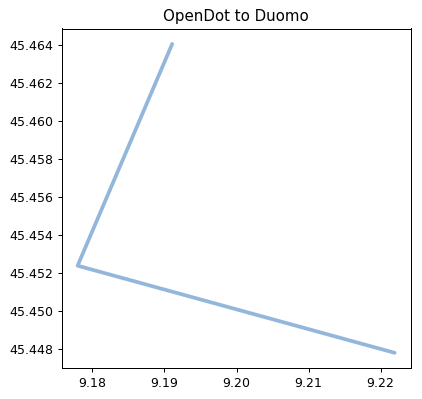

In [33]:
# extract coordinates to plot
x,y = opendot_2_domm.xy

# define a "figure" environment
fig = plt.figure(1, figsize=(5,5), dpi=90)

# add a subplot environment in case we want multiple plots
ax = fig.add_subplot(111)

# add some style
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

# set the title
ax.set_title('OpenDot to Duomo')

# plot!
plt.show()

and a Polygon (you get the idea...)

In [34]:
domm_shape = Polygon([(
        9.19055700302124,
        45.46389314420728
    ),
    (
        9.19257402420044,
        45.46389314420728
    ),
    (
        9.19257402420044,
        45.46448007254733
    ),
    (
        9.19055700302124,
        45.46448007254733
    ),
    (
        9.19055700302124,
        45.46389314420728
    )])

In [35]:
# Calculate the polygon centroid
domm_shape_centroid = domm_shape.centroid
    
# ...its area
domm_shape_area = domm_shape.area

# ...bounding box
domm_shape_bbox = domm_shape.bounds

# ...perimeter
domm_shape_ext = domm_shape.exterior

# the length of the exterior
domm_shape_ext_length = domm_shape.length

### Geometry operations

Once built, operating on Shapely's geometries is then pretty straightforward.

In [36]:
# make a buffer around Opendot's location
opendot_buffer = opendot.buffer(0.005)

In [37]:
# check if Opendot itself is contained in it
print "It is {} that Opendot location is within its buffer".format(opendot.within(opendot_buffer))

# check if the buffer contains duomo
print "Does this buffer contain Duomo's location? {} ".format(opendot_buffer.contains(domm)) 

print "is the path from Opendot to Duomo crossing the buffer? {}".format(opendot_2_domm.intersects(opendot_buffer))


It is True that Opendot location is within its buffer
Does this buffer contain Duomo's location? False 
is the path from Opendot to Duomo crossing the buffer? True


## I/O with Fiona

Fiona is *"OGR's neat and nimble API for Python programmers"* (source [Fiona Docs](https://github.com/Toblerity/Fiona)). It exposes an interface to OGR, C++ open source library for vector formats I/O and conversion. This means that you can use Python to read (and write) a variety of vector file formats!

So let's use Fiona save our points to a ShapeFile

In [38]:
# schema to mimic a GeoJSON structure
schema = {'geometry': 'Point', 'properties': {'name': 'str'}}

# array containing multiple objects
points = [domm, navigli, opendot]

# write file to the filesystem
with collection("points.shp", "w", "ESRI Shapefile", schema) as output:
    for point in points:
        output.write({
            'properties': {
                'name': point.name
            },
            'geometry': mapping(point)
        })

if we then combine Fiona's IO capabilities with the "Shapely way" of manipulating geometries we can obtain pretty sweet results. Note how we use the `buffer()` method from Shapely directly when writing a new file?

In [39]:
with collection("points.shp", "r") as input:
    schema = {'geometry': 'Polygon', 'properties': {'name': 'str'}}
    with collection( "points_buffer.shp", "w", "ESRI Shapefile", schema) as output:
        for point in input:
            output.write({
                'properties': {
                    'name': point['properties']['name']
                },
                'geometry': mapping(shape(point['geometry']).buffer(0.005))
            })

Ok, that was the low level way of building and working with geographic features...But there must be an easier way!

![](../imgs/easier.jpg)

# ENTER (GEO)PANDAS!

A **Geopandas dataframe** implements a Pandas-like datastructure, with the additional feature of understanding spatial data, effectively extending Pandas' lexycon into the geospatial world!

From the [Geopandas Docs](http://geopandas.org/):
> [Geopandas] allows spatial operations on geometric types. Geometric operations are performed by **shapely**. Geopandas further depends on **fiona** for file access and descartes and **matplotlib** for plotting

Look at the names in bold; do the sound familiar? ;)

Let's see what we can do with GeoPandas:

In [55]:
# importing a shapefile is a breeze with Geopandas!
buffers = gpd.read_file(filename="points_buffer.shp")
buffers.head()

,geometry,name
0,"POLYGON ((9.196068 45.464041, 9.19604392363336...",Duomo
1,"POLYGON ((9.18294 45.45238, 9.182915923633361 ...",Navigli
2,"POLYGON ((9.226946000000002 45.447798, 9.22692...",OpenDot


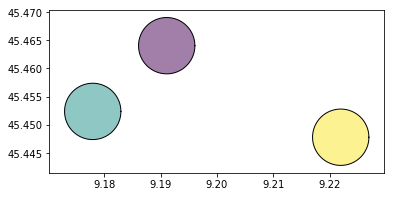

In [56]:
buffers.plot()
plt.show()

but let's some more meaningful dataset...like the BikeMi stations and Milan's census blocks (NIL)

In [57]:
# import BikeMi stations
bike_mi = gpd.read_file(filename="../data/BIKE_SH.shp")
# check the intial rows
bike_mi.head()

,ANNO,BIKE_SH,ID,INDIRIZZO,LOCALIZ,STALLI,geometry
0,2008,001 Duomo 1,1,P.za Duomo,Carreggiata,24,POINT (1514805.505151672 5034614.816062573)
1,2008,002 San Babila,2,P.za S.Babila,Marciapiede,24,POINT (1515473.721959682 5034810.752500436)
2,2008,003 Cadorna 1,3,P.za Cadorna,Marciapiede,21,POINT (1513759.627472495 5034976.764064158)
3,2008,004 Lanza,4,L.go Greppi,Marciapiede,24,POINT (1514251.704793887 5035452.372596722)
4,2008,005 Università Cattolica,5,P.za S.Ambrogio,Marciapiede,24,POINT (1513826.207538738 5034425.72845157)


See that field called **geometry**? That's where the spatial representation of each feature in the dataset gets saved. As mentioned before, the features are stored using Shapely's model. It is therefore possible to interact with them using the usual functionalities of Shapely! 

The geometry field is also useful for (re)projecting the data and/or modify the features

In [58]:
# what is bike_mi's initial projection?
print bike_mi.crs

# save the shapefile CRS in a variable for later use
prj = bike_mi.crs

{u'lon_0': 9, u'k': 0.9996, u'ellps': u'intl', u'y_0': 0, u'no_defs': True, u'proj': u'tmerc', u'x_0': 1500000, u'units': u'm', u'lat_0': 0}


Geopandas allows also a *quick-and-easy* way to visually inspect the data

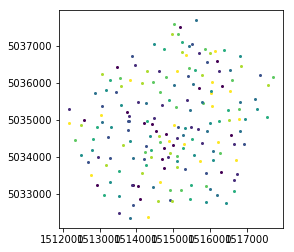

In [59]:
# let's plot the newly imported geometries
bike_mi.plot()
plt.show()

but its true strenght lies in the Pandas datastructure. Manipulating/Slicing/Subsetting data becomes (almost) a breeze. For instance, let's select only the newest BikeMi stations:

In [60]:
# check how many years are present in the data
bike_mi.ANNO.unique()

array([2008, 2009, 2012, 2011, 2013])

In [61]:
# slice the dataset selecting only the stations from 2013
stations_2013 = bike_mi[bike_mi.ANNO == 2013]
stations_2013.head()

,ANNO,BIKE_SH,ID,INDIRIZZO,LOCALIZ,STALLI,geometry
107,2013,109 Tunisia - Lecco - Bellintani,109,V.le Tunisia - Bellintani,Marciapiede,30,POINT (1516045.226974665 5036023.154826893)
109,2013,111 B. Marcello - Boscovich,111,Via Benedetto Marcello,Marciapiede,36,POINT (1516248.323389268 5036336.48115693)
113,2013,115 Caiazzo,115,P.zza Caiazzo,Marciapiede,36,POINT (1516372.610577578 5036899.874652725)
115,2013,117 Bacone - Monteverdi,117,"Via Monteverdi, angolo Bacone",Marciapiede,36,POINT (1516823.976258267 5036469.798320907)
119,2013,121 Galvani - Copernico,121,"Via Gioia, angolo Galvani",Marciapiede,27,POINT (1515497.594797405 5037057.317684159)


## Spatial operations

Now that we can harness the power of Geopandas, let's use it in conjuction with Shapely's capabalities. For instance, let's see how many to BikeMi stations are available for each census block.

Remember the BikeMi CRS? Before doing anything, we need to make sure both our datasets "live" in the same space. or otherwise any geometrical operations will result in an empty set!


In [62]:
nil = gpd.read_file(filename="../data/NIL/NILZone.shp")
nil.head()

,AreaHA,AreaMQ,FID_1,FID_1_1,ID_NIL,NIL,geometry
0,70.84658,7.084658e+05,0,0,74,SACCO,"POLYGON ((1509552.719044713 5040303.760969574,..."
1,92.67346,9.267346e+05,1,1,82,COMASINA,"POLYGON ((1513215.688678416 5041192.970880653,..."
2,56.00979,5.600979e+05,2,2,75,STEPHENSON,"POLYGON ((1510129.918986993 5039633.206036629,..."
3,102.44374,1.024437e+06,3,3,66,QT 8,"POLYGON ((1511256.433874341 5036831.711316778,..."
4,140.25196,1.402520e+06,4,4,29,ORTOMERCATO,"POLYGON ((1518588.94814109 5033641.931635757, ..."


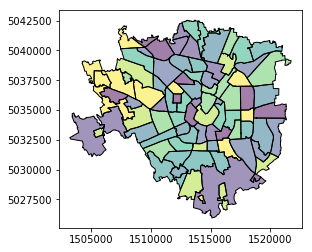

In [63]:
nil.plot()
plt.show()

In [67]:
# check for CRS equality
print "Do the two datasets live in the same CRS? {}".format(nil.crs == bike_mi.crs)

# newest_stations.crs
print "{} {}".format(nil.crs, bike_mi.crs)

Do the two datasets live in the same CRS? True
{u'lon_0': 9, u'k': 0.9996, u'ellps': u'intl', u'y_0': 0, u'no_defs': True, u'proj': u'tmerc', u'x_0': 1500000, u'units': u'm', u'lat_0': 0} {u'lon_0': 9, u'k': 0.9996, u'ellps': u'intl', u'y_0': 0, u'no_defs': True, u'proj': u'tmerc', u'x_0': 1500000, u'units': u'm', u'lat_0': 0}


If Shapely is used to perform operations on the geometries, Geopandas has really convenient methods to perform other "classic" GIS functions, such as **Spatial Joins** (in addition to regular joins). 

A spatial join is simply a way to merge two datasets on their spatial relationship, rather than on a common property (such as in a SQL join). The output is a new dataset (similary to, for instance a count-in-polygon/select-by-location method of some GIS softwares), with the addition of merging the characteristics of the two original datasets. 

There are three possible types of Spatial Joins, according to the relation between the features:
- intersects
- within
- contains

Let's use our previously calculated buffers to select only stations nearby Duomo. We have to:
- Join the BikeMi stations with the buffers, thereby obtaining a new dataset with an additional field "name".
- Use such field to subset the newly created dataset and select only the appropriate stations

In [68]:
# spatial join
join = gpd.sjoin(nil, bike_mi, how="inner", op="contains")

# Let's check the result
join.head()

,AreaHA,AreaMQ,FID_1,FID_1_1,ID_NIL,NIL,geometry,index_right,ANNO,BIKE_SH,ID,INDIRIZZO,LOCALIZ,STALLI
27,220.74874,2.207487e+06,27,27,22,CITTA' STUDI,"POLYGON ((1518351.398164845 5035093.556490595,...",185,2013,214 Piazzale Susa,214,Isola spartitraffico Sidoli - Romagna,Marciapiede,30
27,220.74874,2.207487e+06,27,27,22,CITTA' STUDI,"POLYGON ((1518351.398164845 5035093.556490595,...",186,2013,215 Politecnico 1,215,piazzale Leonardo da Vinci lato nord,Marciapiede,36
27,220.74874,2.207487e+06,27,27,22,CITTA' STUDI,"POLYGON ((1518351.398164845 5035093.556490595,...",187,2013,216 Romagna - Pascoli,216,Via Pascoli 53,Carreggiata,36
32,154.80207,1.548021e+06,32,32,4,GUASTALLA,"POLYGON ((1516175.103382475 5035420.086457941,...",12,2008,013 Senato,13,Via Senato,Marciapiede,18
32,154.80207,1.548021e+06,32,32,4,GUASTALLA,"POLYGON ((1516175.103382475 5035420.086457941,...",71,2009,073 Majno - Baretti,73,Via Baretti,Carreggiata,24


Seems like everything worked fine...to save then the file just use the gppt.file() function, with Fiona drivers

In [70]:
join.to_file(driver="ESRI Shapefile" ,filename="../join.shp")

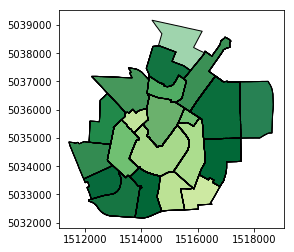

In [103]:
# plot using Yellow to Green color map from PySAL
join.plot(column="STALLI", cmap="YlGn")
plt.show()

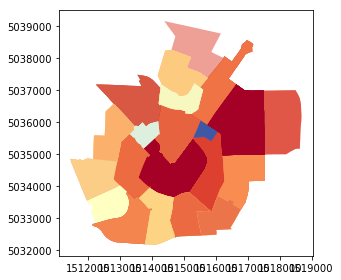

In [104]:
# easy calculation of a new field
join['stations_by_area'] = join['STALLI'] / join['AreaMQ']

# plotting with new color map and classification
join.plot(column="stations_by_area", scheme="Fisher_Jenks", k=9, cmap="RdYlBu", linewidth=0);

# Use tight layour
plt.tight_layout()
plt.show()

# PLOTTING WITH BOKEH AND FOLIUM

There are two main libraries for plotting interactive maps in Python, Folium and Bokeh. While Bokeh is the new shiny library that provide interactive charting and visualization capabilities in a python notebook (based on BokehJS), Folium is a more "tested" approach that exposes the widespread LeafletJS library to Python.

![](../imgs/folium.jpeg)


In [12]:
import folium
import pandas as pd


map = folium.Map(location=[45.458056, 9.198762], tiles='Stamen Toner',zoom_start=13)
folium.Marker(location=[45.447798, 9.221946], popup='Hallo from OpenDot!').add_to(map)
folium.Marker(location=[45.464041, 9.191068], popup='La mi bela Madunina!').add_to(map)
folium.CircleMarker(location=[45.447798, 9.221946], radius=50,
                    popup="I'm a polygon..well sort of ", color='#E4819F',
                    fill_color='#E4819F').add_to(map)
map
# if you want to export your map
# map.save('easy_map.html')


while Folium is a nice addition to your Jupyter arsenal -or simply to interact with live maps- if you want *deployable* maps of a certain quality, then I'd say...go directly for [LeafletJS](http://leafletjs.com/) :D

![](../imgs/logo.svg)

Bokeh is a new(ish) python visualization package which aims to "targets modern web browsers for presentation". 

It exposes different level of API interfaces:

> - a low-level bokeh.models interface that provides the most flexibility to application developers.
- an intermediate-level bokeh.plotting interface centered around composing visual glyphs.
- a high-level bokeh.charts interface to build complex statistical plots quickly and simply.

Bokeh projects usually involve a series of
steps:
>- Read the Shapefile into GeoDataFrame
- Calculate the x and y coordinates of the geometries into separate columns
- Convert the GeoDataFrame into a Bokeh DataSource
- Plot the x and y coordinates as points, lines or polygons (which are in Bokeh words: circle, multi_line and patches)

(source [Bokeh Docs](http://bokeh.pydata.org/en/latest/) )

In [13]:
from bokeh.plotting import figure, save, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, WheelZoomTool
import geopandas as gpd
import pysal as ps

output_notebook()
# Initialize the plot (p) and give it a title
# p = figure(title="NIL plot with bokec!")


# courtesy of https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-bokeh.html
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""

    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1] )

# Get the Polygon x and y coordinates
join['x'] = join.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
join['y'] = join.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)


# Make a copy, drop the geometry column and create ColumnDataSource
g_df = join.drop('geometry', axis=1).copy()
gsource = ColumnDataSource(g_df)

# Let's first do some coloring magic that converts the color palet into map numbers (it's okey not to understand)
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

# Create the color mapper
color_mapper = LogColorMapper(palette=palette)


# Initialize our figure
p = figure(title="BikeMI Stations' Density - Milan Census Block (NIL) level")

# Plot grid
p.patches('x', 'y', source=gsource,
         fill_color={'field': 'stations_by_area', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.01)


# Save the figure
outfp = r"./index.html"
save(p, outfp)
show(p)

Loading BokehJS ...

NameError: name 'join' is not defined

# References

All of the above is largely based on the following (awesome!) resource:
- [Shapely Docs](http://toblerity.org/shapely/manual.html))
- [Tenkanen H. (2016), Automating GIS processes](https://automating-gis-processes.github.io/2016/index.html)
- [Westra E. (2013)](https://www.packtpub.com/application-development/python-geospatial-development-second-edition)
- [MacWrigh, T. (2013), GIS with Python, Shapely, and Fiona](http://www.macwright.org/2012/10/31/gis-with-python-shapely-fiona.html)